In [18]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

import sys
#print (sys.path)
sys.path.append('/home/gf/pakages/miniconda3/lib64/python3.5/site-packages/rpy2-2.8.3-py3.5-linux-x86_64.egg/')

ps_full = pd.read_table('../data/PrimaryScreen.tsv')
odors = pd.read_table("../data/Odors.tsv")
receptors = pd.read_table("../data/Receptors.tsv")
ps = ps_full
ps['NormalizedLuc'] = ps['Luc'] #/ps['RL']
#ps['NormalizedLuc'] = (ps['Luc'])**3/(ps['RL'])**1.2

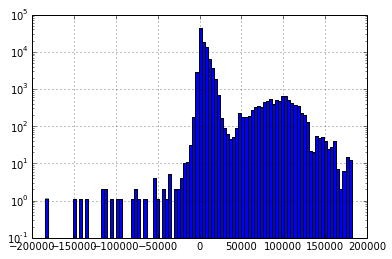

In [19]:
ps1 = ps[ ps['Odor'] != 9999] # Has an odor
ps0 = ps[ ps['Odor'] == 9999] # no-odor control
base_names=["Plate0", "Well0", "Concentration0", "Luc0","RL0", "OR", "Odor0", "Date", "NormalizedLucBase"]
ps0 = ps0.rename(columns=dict(zip(ps0.columns.tolist(), base_names)))

psmerge = pd.merge(ps1, ps0, on=["OR", "Date"])
psmerge['Baselined'] = psmerge['NormalizedLuc']-psmerge['NormalizedLucBase']

def rank(col):
    df = pd.DataFrame()
    r1 = col.sort_values().index.values
    df['i'] = np.arange(1,r1.shape[0]+1)
    df['rank'] = r1
    df = df.set_index('i') 
    return df['rank'].sort_values().index.values

psmerge['PrimaryScreenRank'] = psmerge['NormalizedLucBase'].shape[0] - rank(psmerge['Baselined'])

psmerge['Baselined'].hist(bins=100, bottom=0.1)
plt.yscale("log", nonposx='clip')

In [20]:
ss = pd.read_table("../data/SecondaryScreen.tsv")

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def aov(ssn):
    formula = 'NormalizedLuc ~ Concentration'
    model = ols(formula, ssn).fit()
    aov_table = anova_lm(model, typ=2)
    return aov_table['PR(>F)']['Concentration']

res=[[k[0],k[1],aov(gp)] for k, gp in ss.groupby(['Odor','OR'])]

ssResults = pd.DataFrame([], columns=['Odor','OR','UncorrectedSecondaryP','TestedInSecondary'])
for k, gp in ss.groupby(['Odor','OR']):
    ssResults = ssResults.append(pd.DataFrame([[k[0],k[1],aov(gp),1]], 
                                              columns=['Odor','OR','UncorrectedSecondaryP','TestedInSecondary']))
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

stats = importr('stats')

ssResults['SecondaryP'] = stats.p_adjust(FloatVector(ssResults['UncorrectedSecondaryP'].values), method = 'fdr')
ssResults['PassedSecondary'] = ssResults['SecondaryP']<0.05

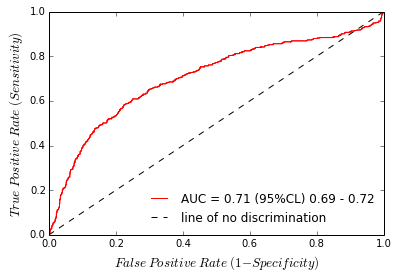

In [21]:
psROC1 = pd.merge(psmerge[["OR","Odor","Baselined"]], ssResults, on=["OR","Odor"],how='outer')
psROC1['TestedInPrimary'] = 1
psROC1['TestedInSecondary'] = psROC1['TestedInSecondary'].fillna(0)
psROC1 = psROC1[~psROC1['Baselined'].isnull()]

grp = psROC1['PassedSecondary']
pred = psROC1['Baselined']
usegrp = ~psROC1['PassedSecondary'].isnull()#.fillna(False)
usepred = ~psROC1['Baselined'].isnull()
grp = grp[usegrp & usepred]
pred = pred[usegrp & usepred]

a = pd.concat([pred,grp], axis=1).set_index('Baselined').sort_index().rename(columns={'PassedSecondary': 'False'})
a['True'] = a['False']
a['True'] = np.where(a['True'],1,0)
a['False'] = np.where(a['False'],0,1)
a['True'] = np.cumsum(a['True'])
a['False'] = np.cumsum(a['False'])
tn = a['True']
fn = a['False']
tp = fn[sorted(fn.keys())[-1]] - fn
fp = tn[sorted(tn.keys())[-1]] - tn
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
roc = pd.concat([fpr,tpr], axis=1).sort_index(ascending=False)
roc.rename(columns={'False':'x','True':'y'}, inplace=True)

auc = 0
for i in range(2,roc.shape[0]):
    auc += (roc['x'].values[i] - roc['x'].values[i - 1])*(roc['y'].values[i] + roc['y'].values[i - 1])/2

pos = pred[grp == True]
neg = pred[grp == False]

q1 = auc/(2-auc)
q2 = (2*auc**2)/(1+auc)

se_auc = np.sqrt((   (auc * (1 - auc)) + ((pos.shape[0] -1)*(q1 - auc**2))
      + ((neg.shape[0] -1)*(q2 - auc**2)))/(pos.shape[0]*neg.shape[0]))
ci_upper = auc + (se_auc * 0.96)
ci_lower = auc - (se_auc * 0.96)

se_auc_null = np.sqrt((1 + pos.shape[0] + neg.shape[0])/(12*pos.shape[0]*neg.shape[0]))
z = (auc - 0.5)/se_auc_null
p = 2*norm.ppf(-abs(z))


plt.plot(roc['x'],roc['y'], 'r')
x0 = np.linspace(0,1,roc.shape[0])

s = "AUC = %1.2f (95%%CL) %1.2f - %1.2f"% (auc,ci_lower,ci_upper)
plt.plot(roc['x'],roc['y'], 'r', label=s)
plt.plot(x0,x0, 'k--', label="line of no discrimination")

plt.xlabel(r"$False\ Positive\ Rate\ (1-Specificity)$",fontsize=13)
plt.ylabel(r"$True\ Positive\ Rate\ (Sensitivity)$",fontsize=13)

plt.legend(loc='best', frameon=False)

In [4]:
plt.savefig('ROC.jpg')